In [25]:
#automatically reload stuff
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import re
import Formatting
from scipy import stats
import Metrics
from Constants import Const
import copy
import Utils
from Models import PatientKNN
import Cluster
from SymptomPreprocessing import *

from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.stats import power_divergence, chisquare, chi2_contingency
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

from dtaidistance import dtw_ndim, clustering
pd.set_option('display.max_columns', None)


In [2]:
from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
#Andrews code for formatting the symptom data

In [4]:
df = load_mdasi()
imputed_df = impute_and_group(df,use_domains=True)
imputed_df

before drop count 823
after drop count 535


/media/andrew/DATA1/git_repos/QubbedDataAnalysis/python/SymptomPreprocessing.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  val_df[name] = timestep


error (%) 0.7424412531907885
[('severe_6wk_symptoms', 0.009345794392523364), ('severe_late_symptoms', 0.014953271028037384), ('moderate_6wk_symptoms', 0.052336448598130844), ('moderate_late_symptoms', 0.04672897196261682), ('mild_6wk_symptoms', 0.19626168224299065), ('mild_late_symptoms', 0.17009345794392525)]


id             chemotherapy is_ajcc_8th_edition   rt   nd typetreatment  \
0      1  concurrent_chemotherapy               False  1.0  0.0            Cr   
1      7  concurrent_chemotherapy               False  1.0  0.0            Cr   
2      8  concurrent_chemotherapy               False  1.0  0.0            Cr   
3      9  concurrent_chemotherapy               False  1.0  1.0           CrS   
4     10     induction+concurrent                  -1  1.0  0.0           ICr   
..   ...                      ...                 ...  ...  ...           ...   
530  811  concurrent_chemotherapy                True  1.0  NaN             R   
531  813  concurrent_chemotherapy                True  1.0  NaN             R   
532  816                      NaN                True  1.0  NaN            IR   
533  819  concurrent_chemotherapy                True  1.0  NaN           c-R   
534  823                      NaN                True  1.0  NaN          Ic-R   

     followup_days performance_score   age  rt_type   os  duration  is_male  \
0            203.0                 0  72.0      3.0    0  44.00000     True   
1           1201.0                 1  48.0      5.0    1  24.95833     True   
2           1619.0                 0  61.0      2.0    1  41.00000     True   
3           1884.0                 0  50.0      2.0    1  44.00000     True   
4            476.0                 1  70.0      2.0    0  44.00000     True   
..             ...               ...   ...      ...  ...       ...      ...   
530          147.0                 0  54.0      5.0    1       NaN     True   
531           39.0                 0  68.0      3.0    1       NaN     True   
532            NaN               NaN  78.0      2.0  NaN       NaN     True   
533          138.0                 0  52.0      3.0    1       NaN    False   
534            NaN               NaN  74.0      NaN  NaN       NaN     True   

    n_stage subsite  hpv  concurrent treatment2   ic t_stage  \
0       n2b     BOT  1.0         1.0         Cr  0.0      t1   
1       n2b     NOS  0.0         1.0         Cr  0.0      t0   
2       n2c     BOT  1.0         1.0         Cr  0.0      t2   
3       n2a  Tonsil  1.0         1.0        SCr  0.0      t1   
4       n2b     BOT  1.0         1.0        ICr  1.0      t4   
..      ...     ...  ...         ...        ...  ...     ...   
530      n1  Tonsil -1.0         0.0        NaN  0.0      t2   
531     NaN     NOS -1.0         0.0        NaN  0.0     NaN   
532      n1     BOT -1.0         0.0        NaN  1.0      tx   
533      n1     BOT -1.0         NaN        NaN  0.0      t1   
534      n1     NOS -1.0         NaN        NaN  1.0      t0   

                                             dates  \
0    [0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]   
1    [0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]   
2    [0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]   
3    [0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]   
4    [0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]   
..                                             ...   
530  [0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]   
531  [0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]   
532  [0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]   
533  [0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]   
534  [0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]   

                                symptoms_pain_original  \
0    [1.0, nan, nan, nan, nan, nan, 5.0, 7.0, 3.0, ...   
1    [0.0, 0.0, 1.0, 4.0, 3.0, nan, 8.0, nan, 5.0, ...   
2    [4.0, 7.0, nan, nan, nan, nan, nan, nan, 0.0, ...   
3    [0.0, 1.0, nan, nan, 2.0, 4.0, 4.0, 7.0, 2.0, ...   
4    [0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 6.0, 7.0, 0.0, ...   
..                                                 ...   
530  [1.0, nan, 1.0, nan, nan, 3.0, nan, 4.0, nan, ...   
531  [0.0, nan, 1.0, 1.0, 4.0, 4.0, 3.0, 4.0, nan, ...   
532  [1.0, 0.0, nan, 2.0, 3.0, 4.0, 3.0, 2.0, nan, ...   
533  [0.0, 1.0, 1.0, nan, nan, 6.0, nan, nan, nan, ...   
534  [2.0, 2.0, 0.0, 1.0, 0.

In [5]:
# imputed_df.to_csv(Const.data_dir + 'patient_symptom_formatted.csv')

In [19]:
def get_sim_measures(names):
    sim_measure_namedict = {
        'dtw': Metrics.DTWd2d,
        'dtwi': Metrics.DTWi2d,
        'em': Metrics.Wasserstein2d,
        'euclidean': Metrics.Euclidean2D,
        'cosine': Metrics.Cosine2d,
        'chi2': Metrics.ChiSquared2d,
        'jaccard': Metrics.Jaccard2d
    }
    simdict = {}
    for name in names:
        mclass = sim_measure_namedict.get(name)
        if name is not None:
            simdict[name] = mclass()
            simdict[name+'_delta'] = mclass(use_derivative=True)
            #aggregate doesn't apply to dependent dynamic time warping
            if name == 'dtw':
                continue
            simdict[name+'_max'] = mclass(aggregate='max')
            simdict[name+'_delta_max'] = mclass(aggregate='max',use_derivative=True)
        else:
            print('invalid measure name',name)
    return simdict

def simplify_symptoms(array):
    def simple(val):
        if val <= 2:
            return 0
        if val <= 5:
            return 1
        if val <= 7:
            return 2
        return 3
    return np.vectorize(simple)(np.copy(array))


def contingency(v1,v2):
    n_v1 = len(np.unique(v1))
    n_v2 = len(np.unique(v2))
    table = np.zeros((n_v1,n_v2))
    for i, vv1 in enumerate(np.unique(v1)):
        for ii,vv2 in enumerate(np.unique(v2)):
            in_cell = (v1 == vv1) & (v2 == vv2)
            table[i,ii] = in_cell.sum()
    return table

def vector_chi2(x,y):
    x = x.ravel()
    y = y.ravel()
    ctable = contingency(x,y)
    return chi2_contingency(ctable)[1]
    
def make_symptom_clusters(df, 
                          use_groups = True,
                          use_domains=False,
                          sim_measure = None, 
                          n = 3, 
                          link='ward',
                          n_timesteps=8,
                          simplify=True,
                          to_correlate = [
                            'mild_late_symptoms',
                            'moderate_late_symptoms',
                            'severe_late_symptoms',
                            'mild_6wk_symptoms',
                            'moderate_6wk_symptoms',
                            'severe_6wk_symptoms',
                            't_stage','n_stage','os'
                          ]
                         ):
    array = df_to_symptom_array(df,use_groups = use_groups,use_domains=use_domains, simplify = simplify)
    end = min(n_timesteps, array.shape[-1])
    x = array[:,:,0:end]
    clusterer = Cluster.SimilarityClusterer(n,link=link)
    sim_func = sim_measure
    if sim_func is None:
        print('using default similarity')
        sim_func = Metrics.DTWd2d()
    sim = sim_func.get_similarity_matrix(x)
    clusters = clusterer.fit_predict(sim)
    sscore = clusterer.silhouette()

    res = {
        "clusters": clusters, 
        'similarity': sim, 
        'silhouette': sscore,
          }
    if to_correlate is not None and len(to_correlate) > 0:
        vals = df_to_onehot(df,to_correlate)
        for col in vals.columns:
            y = vals[col].values.ravel()
            correlation = 1-vector_chi2(clusters,y)
            res[col+'_chi2'] = correlation
    
    return res

def run_cluster_tests(df):
    links = ['ward']#['ward','single','average','centroid']
    #8 is the last point before the 6 week follow up
    sequence_lengths = [7,8]#[7,8,9,10]#[8,9,10,11,12]
    cluster_counts = [3,4,5]#[3,4,5]
    simplify_options = [False,True]#[False,True]
    use_group_options = [(False,False),(True,False),(True,True)]
    measure_names = ['dtwi','dtw','em']#['euclidean','jaccard','chi2','cosine']
    measure_dict = get_sim_measures(measure_names)
    results = []
    for n in cluster_counts:
        for link in links:
            clusterer = Cluster.SimilarityClusterer(n,link=link)
            for n_timesteps in sequence_lengths:
                for sname, measure in measure_dict.items():
                    for simplify in simplify_options:
                        for use_groups,use_domains in use_group_options:
                            try:
                                entry = make_symptom_clusters(df,
                                                              use_groups = use_groups,
                                                              use_domains=use_domains,
                                                              sim_measure=measure, 
                                                              n=n,
                                                              link=link,
                                                              n_timesteps=n_timesteps,
                                                              simplify=simplify,
                                                             )
                                entry['measure'] = sname
                                entry['clusterer'] = clusterer.brief()
                                entry['n_timesteps'] = n_timesteps
                                entry['simplify'] = simplify
                                entry['n_clusters'] = n
                                entry['grouped'] = use_groups
                                entry['use_domains'] = use_domains
                                print(entry['measure'],entry['simplify'],entry['silhouette'],entry['grouped'],entry['n_clusters'])
                                print([(k,v) for k,v in entry.items() if 'chi2' in k and v > .95])
                                print()
                                results.append(entry)
                            except Exception as e:
                                print(e)

    res = pd.DataFrame(results)
    return res

# res = run_cluster_tests(imputed_df)
# res.to_pickle(Const.data_dir + 'symptom_clusters_1-12-2022.csv')

In [17]:
# res = res_old

In [20]:
res = pd.read_pickle(Const.data_dir + 'symptom_clusters_1-12-2022.csv')
res.sort_values('silhouette',ascending=False)

clusters  \
109  [1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 3, 2, 2, ...   
112  [1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 3, 2, 2, ...   
97   [1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 3, 2, 2, ...   
100  [1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 3, 2, 2, ...   
96   [2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 3, 3, 2, ...   
..                                                 ...   
82   [2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, ...   
267  [4, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
273  [4, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
264  [4, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
270  [4, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                            similarity  silhouette  \
109  [[1.0, 0.38708726415094347, 0.4418492268041238...    0.112934   
112  [[1.0, 0.38708726415094347, 0.4418492268041238...    0.112934   
97   [[1.0, 0.38708726415094347, 0.4418492268041238...    0.112934   
100  [[1.0, 0.38708726415094347, 0.4418492268041238...    0.112934   
96   [[1.0, 0.3537414965986395, 0.3265306122448979,...    0.107175   
..                                                 ...         ...   
82   [[1.0, 0.2546900891740736, 0.35133793269325586...   -0.002061   
267  [[1.0, 0.02340423100123499, 0.0365413282391047...   -0.003167   
273  [[1.0, 0.02340423100123499, 0.0365413282391047...   -0.003167   
264  [[1.0, 0.02340423100123499, 0.0365413282391047...   -0.003167   
270  [[1.0, 0.02340423100123499, 0.0365413282391047...   -0.003167   

     mild_late_symptoms|True_chi2  moderate_late_symptoms|True_chi2  \
109                           1.0                          0.997864   
112                           1.0                          0.997864   
97                            1.0                          0.997864   
100                           1.0                          0.997864   
96                            1.0                          0.998484   
..                            ...                               ...   
82                            1.0                          0.988437   
267                           1.0                          0.996782   
273                           1.0                          0.996782   
264                           1.0                          0.996782   
270                           1.0                          0.996782   

     severe_late_symptoms|True_chi2  mild_6wk_symptoms|True_chi2  \
109                        0.876106                          1.0   
112                        0.876106                          1.0   
97                         0.876106                          1.0   
100                        0.876106                          1.0   
96                         0.835255                          1.0   
..                              ...                          ...   
82                         0.995976                          1.0   
267                        0.713941                          1.0   
273                        0.713941                          1.0   
264                        0.713941                          1.0   
270                        0.713941                          1.0   

     moderate_6wk_symptoms|True_chi2  severe_6wk_symptoms|True_chi2  \
109                         0.999999                       0.999999   
112                         0.999999                       0.999999   
97                          0.999999                       0.999999   
100                         0.999999                       0.999999   
96                          0.999973                       0.940199   
..                               ...                            ...   
82                          0.999215                       0.983877   
267                         0.992921                       0.727004   
273                         0.992921                       0.727004   
264                         0.992921                       0.727004   
270                         0.992921                     

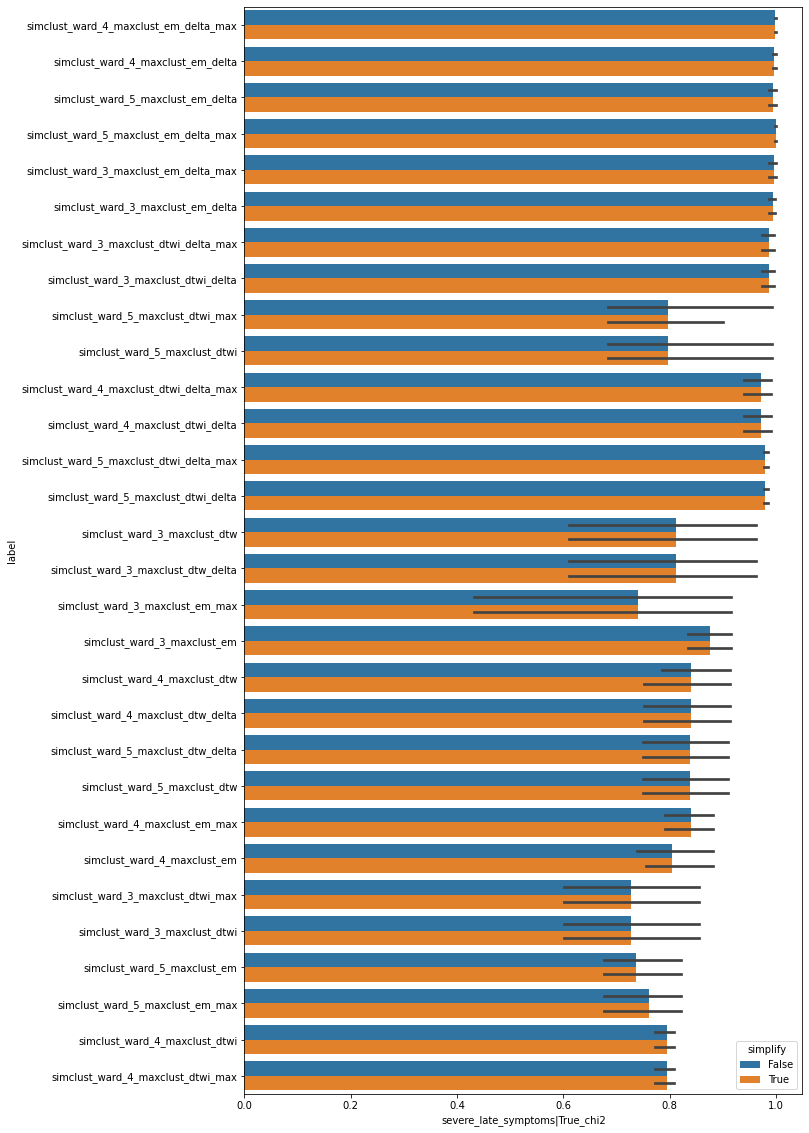

In [21]:
import seaborn as sns

def symptom_cluster_barplot(res, n_timesteps=8, value='severe_late_symptoms|True_chi2'):
    if n_timesteps is not None:
        temp = res[res.n_timesteps == n_timesteps].copy()
    temp['label'] = (temp.clusterer + '_' + temp.measure)
    temp = temp.sort_values(value,ascending=False)
    plt.figure(figsize=(10,20))
    ax = sns.barplot(
        data = temp,
        orient='h',
        y = 'label',
        x = value,
        hue = 'simplify',
    #     order=['severe_late_chi2'],
    )
symptom_cluster_barplot(res)

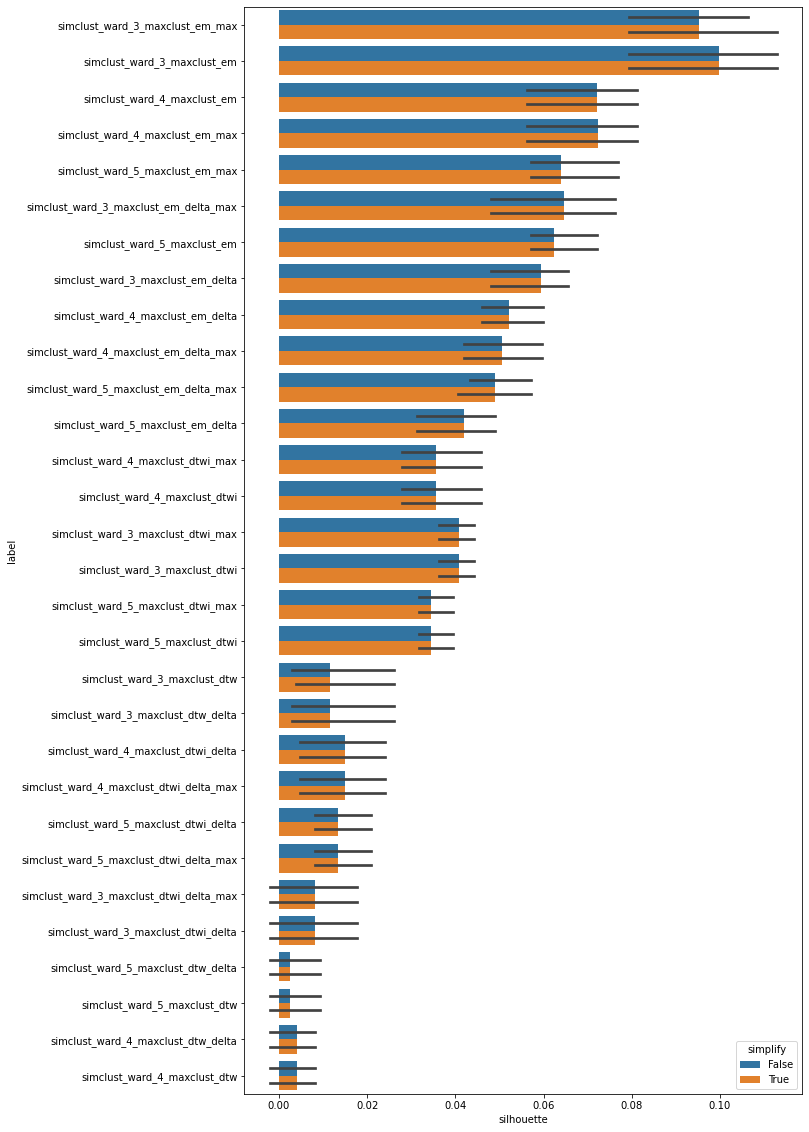

In [22]:
symptom_cluster_barplot(res,value='silhouette')

In [23]:
from matplotlib.patches import Rectangle

def plot_cluster_lines(val_df,clusters,
                        timesteps = None,
                        titles = None,
                        simplify=False, 
                        plot_groups=False,
                        outcome='os',
                        **kwargs,
                       ):
    colors = plt.get_cmap('tab20')
    
    n_timesteps = 10#best_result.n_timesteps
    x = get_plot_x(val_df, simplify, plot_groups)
    
    labels = np.unique(clusters)
    n_channels = x.shape[1]
    if timesteps is None:
        timesteps = np.arange(x.shape[-1])
    n_timesteps = min(len(timesteps),x.shape[-1])
    timesteps=np.array(timesteps)[0:n_timesteps]
    fig,ax = plt.subplots(n_channels,len(labels),figsize=[15,10])
    if titles is None:
        titles = ['cluster ' + str(i) for i in clusters]
    for i,cluster in enumerate(labels):
        #list of lists, i think
        svals = x[clusters == cluster]
        alpha = 1/np.sqrt(svals.shape[0])
        for channel in range(n_channels):
            this_ax = ax[channel,i]
            plt.setp(this_ax, ylim=(0,x.max()))
            entrys = svals[:,channel,:n_timesteps]
            for entry in entrys:
                this_ax.plot(timesteps,entry,color=colors(i),alpha=alpha,linewidth=1.5)
            meanval = entrys.mean(axis=0).ravel()
            this_ax.plot(timesteps,meanval,color='black',alpha=.7,linewidth=2.5)
            if i == 0:
                this_ax.set_ylabel(titles[channel])
            if channel == 0:
                this_ax.set_title('cluster ' + str(cluster) + '_n=' + str(svals.shape[0]))

def plot_cluster_area(val_df,clusters,
                        timesteps = None,
                        titles = None,
                        simplify=False, 
                        plot_groups=False,
                        outcome='os',
                        **kwargs,
                       ):
    colors = plt.get_cmap('tab20')
    
    n_timesteps = 10#best_result.n_timesteps
    x = get_plot_x(val_df, simplify, plot_groups)
    
    labels = np.unique(clusters)
    n_channels = x.shape[1]
    
    if timesteps is None:
        timesteps = np.arange(x.shape[-1])
    n_timesteps = min(len(timesteps),x.shape[-1])
    timesteps=np.array(timesteps)[0:n_timesteps]
    fig,ax = plt.subplots(n_channels,len(labels),figsize=[15,10])
    
    if titles is None:
        titles = ['cluster ' + str(i) for i in clusters]
        
    for i,cluster in enumerate(labels):
        svals = x[clusters == cluster]
        alpha = .75/svals.shape[0]
        for channel in range(n_channels):
            this_ax = ax[channel,i]
            plt.setp(this_ax, ylim=(0,x.max()))
            entrys = svals[:,channel,:n_timesteps]
            for entry in entrys:
                this_ax.plot(timesteps,entry,color=colors(i),alpha=alpha,linewidth=.1)
                this_ax.fill_between(timesteps,entry,color=colors(i),alpha=alpha)
            meanval = entrys.mean(axis=0).ravel()
            this_ax.plot(timesteps,meanval,color='black',alpha=.7,linewidth=2.5)
            if i == 0:
                this_ax.set_ylabel(titles[channel])
            if channel == 0:
                this_ax.set_title('cluster ' + str(cluster) + '_n=' + str(svals.shape[0]))
            
                
def plot_cluster_bands(val_df,clusters,
                        timesteps = None,
                        titles = None,
                        simplify=False, 
                        plot_groups=False,
                        outcome='os',
                        **kwargs,
                       ):
    colors = plt.get_cmap('tab20')
    
    n_timesteps = 10#best_result.n_timesteps
    
    x = get_plot_x(val_df, simplify, plot_groups)
    
    labels = np.unique(clusters)
    n_channels = x.shape[1]
    
    if timesteps is None:
        timesteps = np.arange(x.shape[-1])
    n_timesteps = min(len(timesteps),x.shape[-1])
    timesteps=np.array(timesteps)[0:n_timesteps]
    fig,ax = plt.subplots(n_channels,len(labels),figsize=[15,10])
    
    if titles is None:
        titles = ['cluster ' + str(i) for i in clusters]
        
    for i,cluster in enumerate(labels):
        svals = x[clusters == cluster]
        alpha = .5
        c = colors(cluster)
        for channel in range(n_channels):
            this_ax = ax[channel,i]
            plt.setp(this_ax, ylim=(0,x.max()))
            entrys = svals[:,channel,:n_timesteps]
            meanval = entrys.mean(axis=0).ravel()
            this_ax.plot(timesteps,meanval,color='black',alpha=.7,linewidth=2.5)
            ranges = [.01,.1,.25]
            for r in ranges:
                quantiles = np.quantile(entrys,[r,1-r],axis=0)
                for pos in [0,1]:
                    q = quantiles[pos]
                    this_ax.plot(timesteps,q,color=c,alpha=alpha,linewidth=1)
                this_ax.fill_between(timesteps,quantiles[0],quantiles[1],color=c,alpha=.25)
            if i == 0:
                this_ax.set_ylabel(titles[channel])
            if channel == 0:
                this_ax.set_title('cluster ' + str(cluster) + '_n=' + str(svals.shape[0]))
                
def plot_cluster_rectangles(val_df,clusters,
                        timesteps = None,
                        titles = None,
                        simplify=False, 
                        plot_groups=False,
                        outcome='os',
                        **kwargs,
                       ):
    cat_colors = [
        plt.get_cmap('Greens'),
        plt.get_cmap('Blues'),
        plt.get_cmap('Oranges'),
        plt.get_cmap('GnBu'),
        plt.get_cmap('Greys'),
        plt.get_cmap('Reds'),
        plt.get_cmap('RdPu'),
    ]
    
    n_timesteps = 10#best_result.n_timesteps
    
    x = get_plot_x(val_df, False, plot_groups)
    labels = np.unique(clusters)
    x = simplify_symptoms(x)
    n_channels = x.shape[1]
    
#     if timesteps is None:
    timesteps = np.arange(x.shape[-1])
    n_timesteps = min(len(timesteps),x.shape[-1])
    timesteps=np.array(timesteps)[0:n_timesteps]
    fig,ax = plt.subplots(n_channels,len(labels),figsize=[15,10])
    
    if titles is None:
        titles = ['cluster ' + str(i) for i in clusters]
        
    for i,cluster in enumerate(labels):
        svals = x[clusters == cluster]
        alpha = .5
        cfunc = cat_colors[i]
        csize = svals.shape[0]
        for channel in range(n_channels):
            this_ax = ax[channel,i]
            plt.setp(this_ax,xlim=(0,timesteps.max()), ylim=(0,x.max()+1))
            
            entrys = svals[:,channel,:n_timesteps]
            for yval in range(int(x.max()+1)):
                for xval in timesteps:
                    count = (entrys[:,xval] == yval).sum()
                    ratio = count/csize
                    rect = Rectangle((xval,yval),1,1,color=cfunc(ratio**.75))
                    this_ax.add_patch(rect)
            if i == 0:
                this_ax.set_ylabel(titles[channel])
            if channel == 0:
                this_ax.set_title('cluster ' + str(cluster) + '_n=' + str(svals.shape[0]))


def plot_cluster_radar(val_df,clusters,
                        timesteps = None,
                        titles = None,
                        simplify=False, 
                        plot_groups=False,
                        outcome='os',
                        **kwargs,
                       ):
    transform = lambda x: np.sqrt(np.array(x))
    n_timesteps = 10#best_result.n_timesteps
    x = get_plot_x(val_df, simplify, plot_groups)

    rticks = [3,5,7]
    x = transform(x)
    rticks = transform(rticks)
    outcome_vals = val_df[outcome].values
    xmax=int(x.max())
    colors = plt.get_cmap('tab20')
    labels = np.unique(clusters)
    n_channels = x.shape[1]
    timesteps = np.arange(x.shape[-1])
    
    n_timesteps = min(len(timesteps),x.shape[-1])
    timesteps=np.array(timesteps)[0:n_timesteps]
    
    radar_size = 5
    fig,ax = plt.subplots(len(labels),n_timesteps,figsize=[radar_size*n_timesteps,radar_size*len(labels)],
                          subplot_kw={'projection': 'polar'})
    if titles is None:
        titles = ['core','inference','hnc']
    
    angles = [2*np.pi*n/n_channels for n in range(n_channels)]
    angles += angles[:1]
    
    qvals = [.1,.25]
    for t in range(n_timesteps):
        tvals = x[:,:,t]
        
        for cidx,l in enumerate(labels):
            this_ax = ax[cidx,t]
            this_ax.set_xticks(angles[:-1])
            this_ax.grid(linewidth=.1)
#             this_ax.set_xticklabels(titles)
            this_ax.set_rticks(rticks)
            plt.setp(this_ax,rlim=(0,xmax))
            cvals = tvals[clusters == l]
            cvals =np.append(cvals,cvals[:,0].reshape(-1,1),axis=1)
            yvals = outcome_vals[clusters==l]
            ymean = round(yvals.mean()*100)
            ccolor = colors(l)
            for q in qvals:
                cquants = np.quantile(cvals,[q,1-q],axis=0)
                this_ax.fill_between(angles,cquants[0],cquants[1],alpha=.1,color=ccolor)
                for ii in [0,1]:
                    entry = cquants[ii]
                    this_ax.plot(angles,entry,alpha=.7,color=ccolor,linewidth=1)
            mval = cvals.mean(axis=0)
            this_ax.plot(angles,mval,alpha=1,color='black',linewidth=2)
            this_ax.set_title(str(outcome) + ':' + str(ymean) + '%')
#     plt.xticks(angles[:-1], np.arange(n_channels), color='white',alpha=.1)
        
            
def plot_cluster_radar2(val_df,clusters,
                        timesteps = None,
                        titles = None,
                        simplify=False, 
                        plot_groups=False,
                        outcome='os',
                        **kwargs,
                       ):
    
    n_timesteps = 10#best_result.n_timesteps
    x = get_plot_x(val_df, simplify, plot_groups)
    xmax = int(x.max())
    outcome_vals = val_df[outcome].values
    rtick_bounds = [3,5,7]
    
#     colors = plt.get_cmap('tab20')
    cat_colors = [
        plt.get_cmap('Greens'),
        plt.get_cmap('Blues'),
        plt.get_cmap('Oranges'),
        plt.get_cmap('GnBu'),
        plt.get_cmap('Greys'),
        plt.get_cmap('Reds'),
        plt.get_cmap('RdPu'),
    ]
    labels = np.unique(clusters)
    n_channels = x.shape[1]
    timesteps = np.arange(x.shape[-1])
    
    n_timesteps = min(len(timesteps),x.shape[-1])
    timesteps=np.array(timesteps)[0:n_timesteps]
    
    radar_size = 5
    fig,ax = plt.subplots(len(labels),n_timesteps,figsize=[radar_size*n_timesteps,radar_size*len(labels)],
                          subplot_kw={'projection': 'polar'})
    if titles is None:
        titles = ['core','inference','hnc']
    
    angles = [2*np.pi*n/n_channels for n in range(n_channels)]
    angles += angles[:1]
    angle_shape = np.array(angles).shape
    plt.xticks(angles[:-1], np.arange(n_channels), color='grey',alpha=.01)
    
    bounds = [.3,.9] #<.5
    for t in range(n_timesteps):
        tvals = x[:,:,t]
        
        for cidx,l in enumerate(labels):
            this_ax = ax[cidx,t]
            this_ax.set_xticks([])#angles[:-1])
#             this_ax.set_xticklabels(titles)
            this_ax.set_rticks(rtick_bounds)
            plt.setp(this_ax,rlim=(0,xmax))
            cvals = tvals[clusters == l]
            cvals =np.append(cvals,cvals[:,0].reshape(-1,1),axis=1)
            yvals = outcome_vals[clusters==l]
            ymean = round(yvals.mean()*100)
            getcolor = cat_colors[cidx]
            ccolor = getcolor(.7)
            
            cquants = np.quantile(cvals,bounds,axis=0)
            for ii in [1]:#[0,1]:
                entry = cquants[ii]
                this_ax.plot(angles,entry,alpha=.5,color=ccolor,linewidth=1)
                
#             mval = cvals.mean(axis=0)
#             this_ax.plot(angles,mval,alpha=1,color=ccolor,linewidth=2)
            
            lower_bound = 0
            for upper_bound in rtick_bounds + [xmax]:
                in_threshold = ((tvals >= lower_bound)&(tvals < upper_bound)).mean()
                if in_threshold <= 0:
                    continue
                if np.all(cquants[1] < upper_bound):
                    break
                fillcolor = getcolor(in_threshold)
                top = np.full(angle_shape,upper_bound)
                bottom = np.full(angle_shape,lower_bound)
                top = np.stack([top,cquants[1]]).min(axis=0)
                bottom = np.stack([bottom,cquants[0]]).max(axis=0)
                bottom = np.stack([bottom,top]).min(axis=0)
                this_ax.fill_between(angles,bottom,top,color=fillcolor,alpha=.7)
                lower_bound = upper_bound
            
            this_ax.set_title(str(outcome) + ':' + str(ymean) + '%')
    
def plot_cluster_embeddings(val_df,clusters,
                            timesteps = None,
                            titles = None,
                            simplify=False, 
                            plot_groups=False,
                            outcome='os',
                            **kwargs
                           ):
    
    n_timesteps = 10#best_result.n_timesteps
    x = get_plot_x(val_df, simplify, plot_groups)
    x = x.reshape((x.shape[0],-1))
#     outcome_vals = val_df[outcome].values
    colors = plt.get_cmap('tab20')
    plot_colors = [colors(c) for c in clusters]
    
    fsize = 10
    nplots = 3
    fig,ax = plt.subplots(1,nplots,figsize=[fsize*nplots,10])
    
    def encircle(p,ax):
        hull = ConvexHull(p)
        poly = plt.Polygon(p[hull.vertices,:],fc='none',ec=colors(l))
        ax.add_patch(poly)
    
    x_pca = PCA(2).fit_transform(x)
    ax[0].scatter(x_pca[:,0],x_pca[:,1],c=plot_colors)
    ax[0].set_title('PCA')
    
    perplexity = 50
    sim_matrix = kwargs.get('sim_matrix')
    if sim_matrix is not None:
        tsne = TSNE(2,perplexity=perplexity,metric='precomputed')
        x_tsne = tsne.fit_transform(sim_matrix)
    else:
        x_pca_2 = PCA(10).fit_transform(x)
        x_tsne = TSNE(2,perplexity=perplexity).fit_transform(x_pca_2)
    ax[1].scatter(x_tsne[:,0],x_tsne[:,1],c=plot_colors)
    ax[1].set_title('TSNE')
    
#     if sim_matrix is not None:
#         isomap = Isomap(n_components=2,metric='precomputed')
#         x_isomap = isomap.fit_transform(sim_matrix)
#     else:
    x_isomap = Isomap(n_components = 2).fit_transform(x)
    ax[2].scatter(x_isomap[:,0],x_isomap[:,1],c=plot_colors)
    ax[2].set_title('Isomap')
    
    
    for l in np.unique(clusters):
        cluster_pca = x_pca[clusters==l]
        encircle(cluster_pca,ax[0])
        cluster_tsne = x_tsne[clusters==l]
        encircle(cluster_tsne,ax[1])
        cluster_isomap = x_isomap[clusters==l]
        encircle(cluster_isomap,ax[2])
        

def get_plot_x(val_df,simplify,plot_groups,n_timesteps=None):
    use_groups = False
    use_domains=False
    if plot_groups == 'groups':
        use_groups = True
    if plot_groups == 'domains':
        use_groups = True
        use_domains = True
    x = df_to_symptom_array(val_df,
                            simplify=simplify,
                            use_groups =use_groups,
                            use_domains=use_domains,
                           )
    if n_timesteps is not None:
        x = x[:,:,:n_timesteps]
    print(x.shape)
    return x
                
def plot_results(res_df, val_df,
                 plot_func = None,
                 dates=None, 
                 select_by='severe_late_symptoms|True_chi2', 
                 sim = None,
                 n_clusters = None,
                 link=None,
                 use_groups = None,
                 use_domains=None,
                 simplify=None,
                 plot_groups = None,
                 n_timesteps=None,
                 print_selection=None,
                ):
    df = res_df.copy()
    if sim is not None:
        df = df[df.measure == sim]
    if n_clusters is not None:
        df = df[df.n_clusters == n_clusters]
    if link is not None:
        df = df[df.clusterer.apply(lambda x: link in x)]
    if simplify is not None:
        df = df[df.simplify == simplify]
    if n_timesteps is not None:
        df = df[df.n_timesteps == n_timesteps]
    if use_groups is not None:
        df = df[df.grouped == use_groups]
    if use_domains is not None:
        df = df[df.use_domains == use_domains]
#     best_result = df.sort_values('silhouette',ascending=False).iloc[0]\
    best_result = df.sort_values(select_by,ascending=False).iloc[0]
    if print_selection is not None and print_selection:
        to_plot = ['measure',
                   'clusterer',
                   'n_clusters',
                   'n_timesteps',
                   'grouped',
                   'use_domains',
                   'simplify',
                   'silhouette',
                   'severe_late_symptoms|True_chi2',
                   'severe_6wk_symptoms|True_chi2',
                  ]
        for n in to_plot:
            print(n, best_result[n])
    clusters = best_result.clusters
    
    if plot_groups is None:
        if best_result.grouped:
            plot_groups = 'groups'
        if best_result.use_domains:
            plot_gorups = 'domains'
    if use_groups == 'groups':
        titles = df_symptom_names(val_df,use_groups=True,
                                  use_domaisn = False,
                                  clean=True)
    elif use_groups == 'domains':
        titles = df_symptom_names(val_df,use_groups=True,
                                  use_domains = True,
                                  clean=True)
    else:
        titles = df_symptom_names(val_df,use_groups=False,
                                  use_domains = False,
                                  clean=True)
    if plot_func is None:
        plot_func = plot_clusters
    outcome_name = re.sub('([a-zA-Z_])|.+',r'\1',select_by)
    #print outcome if it's a measure in hte dataset
    if outcome_name not in val_df.columns:
        outcome_name = 'severe_late_symptoms'
    plot_func(val_df,clusters,timesteps=dates,
              titles=titles,
              simplify=best_result.simplify,
              plot_groups=plot_groups,
              outcome=outcome_name,
              sim_matrix = best_result.similarity,
             )

measure em_delta_max
clusterer simclust_ward_3_maxclust
n_clusters 3
n_timesteps 8
grouped True
use_domains False
simplify False
silhouette 0.06942816772499416
severe_late_symptoms|True_chi2 0.9998695438218234
severe_6wk_symptoms|True_chi2 0.9954772456125813
(535, 6, 13)
(535, 6, 13)
(535, 6, 13)


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/evl/andrew/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/evl/andrew/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


(535, 6, 13)


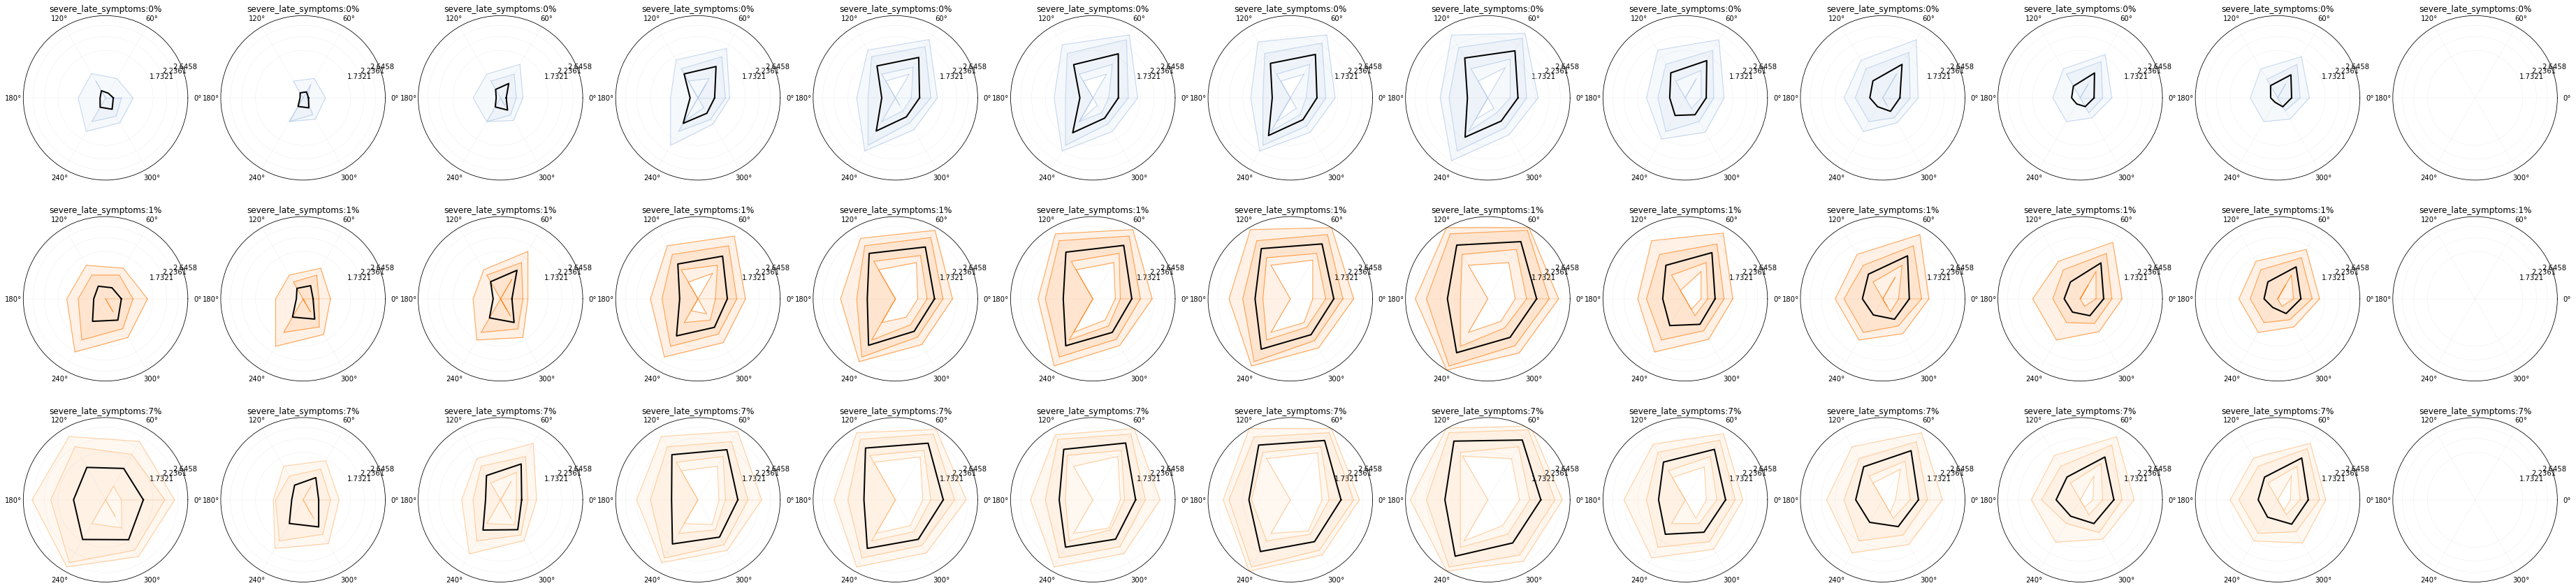

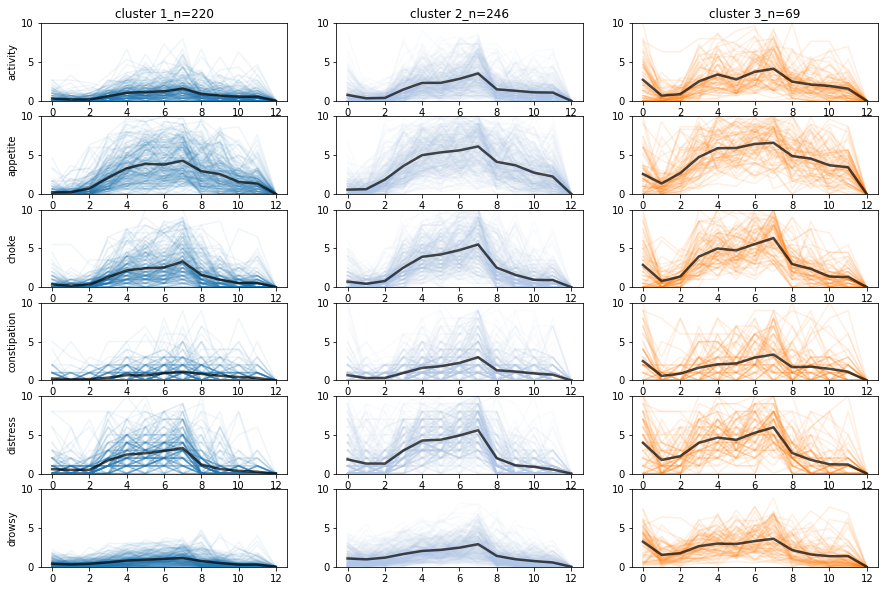

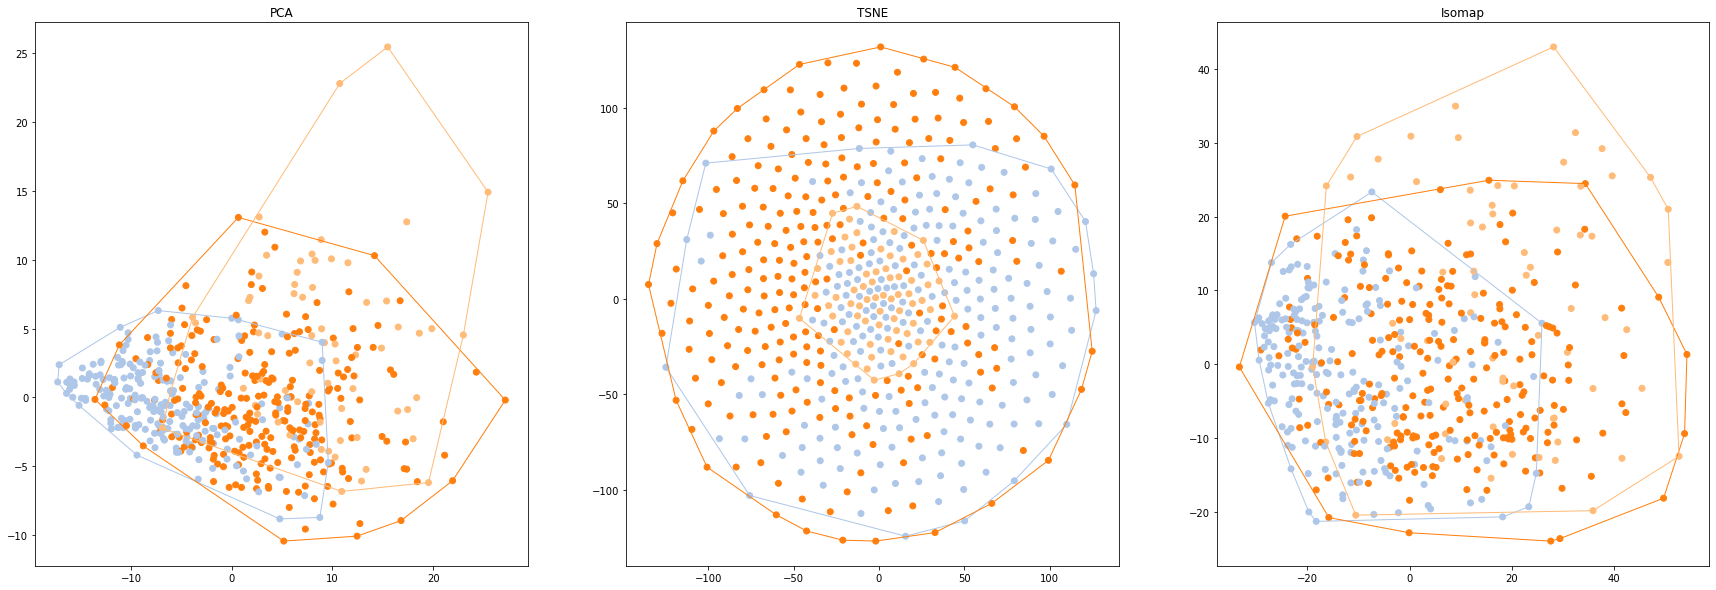

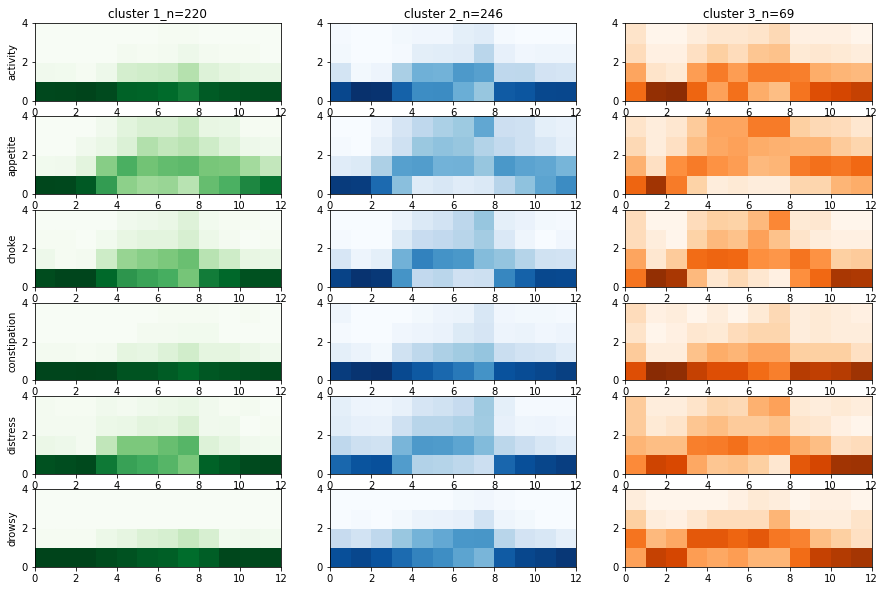

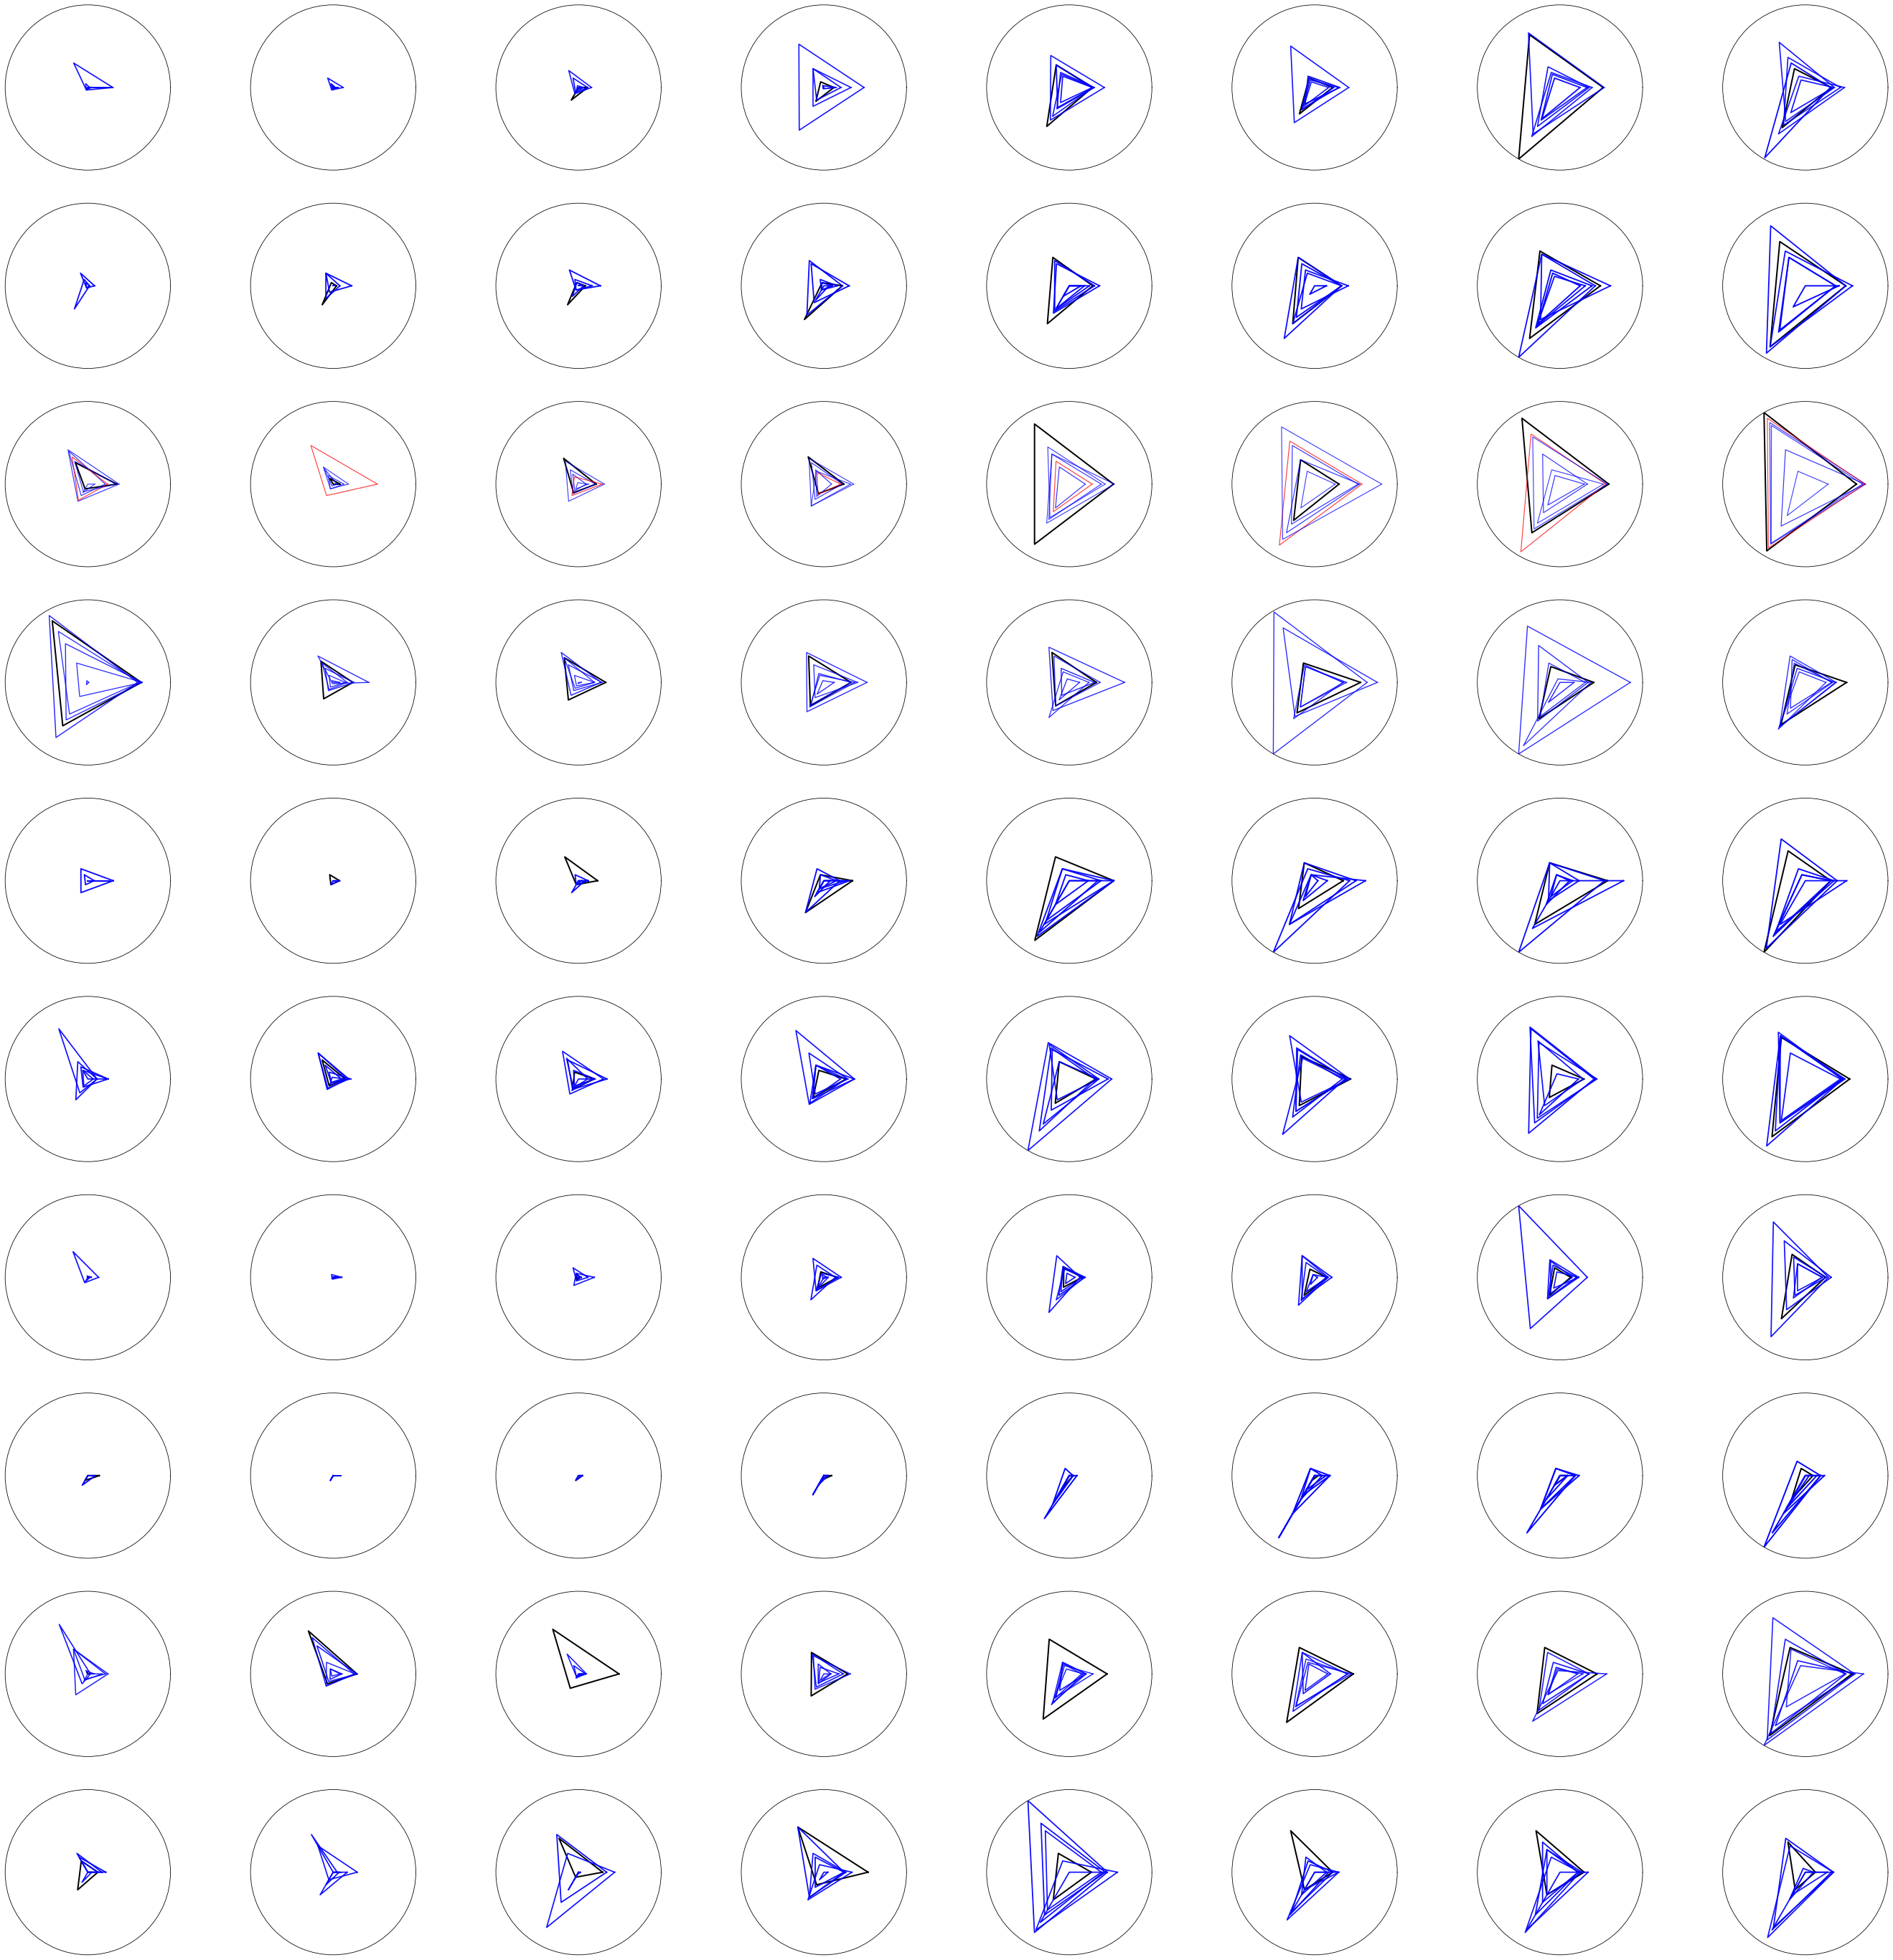

In [34]:
def plot_patient_symptom_lines(x,matches,**kwargs):

    sim_matrix = kwargs.get('sim_matrix')
    clusters = kwargs.get('clusters')
    chart_size = 5
    colors = plt.get_cmap('tab20')
    n_cols = len(matches[0])
    figsize = [n_cols*chart_size*1.2,len(matches)*chart_size]
    fig,ax = plt.subplots(len(matches),n_cols,figsize=figsize)
    
    xaxis = np.arange(x.shape[-1])
    for row,mset in enumerate(matches):
            curr_cluster = clusters[curr_pos]
            curr_color = colors(curr_cluster)
            print(row,col)
            curr_ax = ax[row,col]
            sim = sim_matrix[mset[0],curr_pos]
            pvals = x[curr_pos]
            for p in pvals:
                curr_ax.plot(xaxis,p,color=curr_color)
                curr_ax.set_title('similarity: '+str(np.round( sim, 2) ) )
        
def plot_patient_radars(x,matches,**kwargs):

    sim_matrix = kwargs.get('sim_matrix')
    clusters = kwargs.get('clusters')
    chart_size = 5
    colors = plt.get_cmap('tab10')
    n_cols = x.shape[-1]
    figsize = [n_cols*chart_size*1.2,len(matches)*chart_size]
    fig,ax = plt.subplots(len(matches),n_cols,figsize=figsize,
                         subplot_kw={'projection': 'polar'})
    
    n_channels = x.shape[1]
    angles = [2*np.pi*n/n_channels for n in range(n_channels)]
    angles += angles[:1]
    for tstep in range(x.shape[-1]):
        xslice = x[:,:,tstep]
        for row,mset in enumerate(matches):
            xmax = x[mset].max()
            curr_ax = ax[row,tstep]
            curr_ax.set_xticks([])
            curr_ax.set_rticks([])
            plt.setp(curr_ax,rlim=(0,xmax))
#             curr_ax.set_thetatick_labels([])
            for p,pos in enumerate(mset):
                curr_cluster = clusters[pos]
                curr_color = 'blue' if (curr_cluster == clusters[mset[0]]) else 'red'
                pvals = xslice[pos]
                rvals = list(pvals) + [pvals[0]]
                sim = sim_matrix[mset[0],pos]
                alpha = sim**.5
                lwidth = 2*sim
                if p == 0:
                    curr_color = 'black'
                curr_ax.plot(angles,rvals,
                             color=curr_color,
                             alpha=alpha,
                             linewidth=lwidth)
                
                    
def plot_matches(res_df,val_df,
                 ids = None,
                 random_sample = False,
                 select_by='severe_late_symptoms|True_chi2', 
                 sim = None,
                 n_clusters = None,
                 link=None,
                 use_groups = None,
                 use_domains=None,
                 simplify=None,
                 plot_groups = True,
                 n_timesteps=None,
                 n_neighbors = 5,
                 plot_func=None,
                ):
    df = res_df.copy()
    if sim is not None:
        df = df[df.measure == sim]
    if n_clusters is not None:
        df = df[df.n_clusters == n_clusters]
    if link is not None:
        df = df[df.clusterer.apply(lambda x: link in x)]
    if simplify is not None:
        df = df[df.simplify == simplify]
    if n_timesteps is not None:
        df = df[df.n_timesteps == n_timesteps]
    if use_groups is not None:
        df = df[df.grouped == use_groups]
    if use_domains is not None:
        df = df[df.use_domains == use_domains]
#     best_result = df.sort_values('silhouette',ascending=False).iloc[0]\
    best_result = df.sort_values(select_by,ascending=False).iloc[0]
    sim_matrix = best_result.similarity
    clusters = best_result.clusters
    
    
    matches = PatientKNN(n_match_bounds=[n_neighbors,n_neighbors]).get_matches(sim_matrix)
    if ids is not None:
        val_idx = val_df[val_df.id.apply(lambda i: i in ids)].index
    elif random_sample:
        val_idx = val_df.sample(n=random_sample).index
    else: 
        val_idx = val_df.index

    m = [ [i] + list(matches[i]) for i in val_idx]
    matches = m
    del m
    
    x = df_to_symptom_array(val_df,simplify=simplify,use_groups =plot_groups)
    x = x[:,:,:n_timesteps]
    
    if plot_func is None:
        plot_func = plot_patient_symptom_lines
        
    plot_func(x,matches,clusters=clusters,sim_matrix=sim_matrix)
    
    return 

temp_dates = imputed_df.dates.iloc[0]
plot_args = {
    'n_timesteps': 8,
    'select_by': 'severe_late_symptoms|True_chi2',
#     'select_by': 'silhouette',
    'sim': 'em_delta_max',
    'simplify': False,
    'n_clusters': 3,
#     'use_groups': True,
#     'use_domains': True,
    'plot_groups': 'domains',
}

plot_results(res,imputed_df, 
             plot_func=plot_cluster_radar,
             print_selection=True,
             **plot_args,
            )
plot_results(res,imputed_df, 
             plot_func=plot_cluster_lines,
             **plot_args,
            )
plot_results(res,imputed_df,
             plot_func=plot_cluster_embeddings,
             **plot_args,
            )
plot_results(res,imputed_df, 
             plot_func=plot_cluster_rectangles,
             **plot_args,
            )

plot_matches(res,imputed_df,
             random_sample=10,
             plot_func=plot_patient_radars,
             **plot_args
            )

In [ ]:
# res.to_csv(Const.data_dir + 'cluster_test5(morepatients)_11-23.csv')

In [ ]:
def add_best_clusters(df):
    #for use when I decide what parameters to use
    sim_measure = Metrics.Wasserstein2d(use_derivative=True,aggregate='max')
    results = entry = make_symptom_clusters(df,
                                          use_groups = False,
                                          use_domains=False,
                                          sim_measure=sim_measure, 
                                          n=3,
                                          link='ward',
                                          n_timesteps=8,
                                          simplify=False,
                                        )
    df = df.copy()
    df['clusters'] = results['clusters']
    return df

clustered_df = add_best_clusters(imputed_df)
clustered_df.columns

In [ ]:
clustered_df[['clusters','id']].to_csv(Const.data_dir + 'cluster_results_nogroups_1272021.csv',index=False)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from pandas.api.types import is_numeric_dtype

def predict_loo(model,x,y):
    #currently leave-one-out
    predictions = []
    y = y.reshape(-1,1)
    for i in range(x.shape[0]):
        x_train = np.delete(x, i,axis=0)
        x_test = x[i]
        y_train = np.delete(y,i)
        y_test = y[i]
        
        if x_test.ndim < 2:
            x_test = x_test.reshape(1,-1)
        model.fit(x_train,y_train)
        
        ypred = model.predict_proba(x_test)
        predictions.append(ypred)
    ypred = np.array(predictions)
    ypred = ypred.reshape(x.shape[0],-1)
    return ypred

# def get_metrics(y,ypred,model):
#     squeeze = lambda x: np.argmax(x,axis=1).ravel()
#     y_true = pd.get_dummies(y).loc[:,model.classes_].values#one-hot encoe
#     roc = metrics.roc_auc_score(y_true,ypred[:,1],average='weighted')
#     accuracy = metrics.accuracy_score(y_true, squeeze(ypred))
#     return {'roc': roc, 'accuracy': accuracy}
    
def predict_propensity(df,treatment,covariates,model=None,use_cv=False):
    #assumes binary outcome
    df = df.copy()
    if model is None:
        model = LogisticRegression(solver='lbfgs',multi_class='auto',class_weight='balanced')
    x = df[covariates]
    x = convert_categorical(x).values
    y = df[treatment].values
    
    if use_cv:
        predictions = predict_loo(model,x,y)
    else:
        predictions = model.fit(x,y)
        predictions = model.predict_proba(x)
    model.fit(x,y)
    results  = {'x': x, 'y': y, 'pscore': predictions[:,1], "model": model}
#     metrics = get_metrics(y,predictions,model)
#     results['metrics'] = metrics
    return results
#     propensity = predict_loo(model,x,y)
#     return propensity


def add_pscore(df, treatment,covariates,model=None,use_cv=True):
    pp = predict_propensity(df, treatment,covariates,model=None,use_cv=True)
    df = df.copy()
    df.loc[:,'propensity'] = pp['pscore']
    return df


def convert_categorical(df,cols=None,drop_first=True):
    df = df.copy()
    if cols is None:
        cols = df.columns
    for col in cols:
        try:
            df[col] = df[col].astype('float')
        except:
            categories = df[col].unique()
            if drop_first:
                categories = categories[1:]
            for cat in categories:
                cat_name = str(cat).replace(' ','')
                df.loc[:,str(col)+'_'+cat_name] = df[col] == cat
                df.loc[:,str(col)+'_'+cat_name] = df.loc[:,str(col)+'_'+cat_name].astype('int')
            df = df.drop([col],axis=1)
    return df

def get_nominal(string):
    string = str(string)
    output = re.match('.*(\d+)',string)
    try:
        out = int(output.group(1))
    except:
        out = np.nan
    return out

def add_weights(cdf,treatment,covariates,model=None):
    if 'propensity' not in cdf.columns:
        cdf = add_pscore(cdf.copy(), treatment, covariates,model=model)
    def get_weight(row):
        if row[treatment] == 1:
            weight = 1/row['propensity']
        else:
            weight = 1/(1-row['propensity'])
        return weight
    cdf.loc[:,'weights'] = cdf.apply(get_weight,axis=1)
    return cdf

def match(df, treatment, n_neighbors = 8, max_d = .1, replacement = True):
    #takes binary treatment 
    pscores = df.propensity.values
    is_t = df[treatment].values.astype('bool')
    treated = pscores[is_t]
    control = pscores[~is_t]
    sets = []
    sampled = set([])
    pos = 0
    for i, pscore in enumerate(pscores):
        if not is_t[i]:
            continue
        diff = np.abs(control - pscore)             
        neighbors = np.argsort(diff)[0:n_neighbors]
        valid_n = (diff[neighbors] <= max_d)
        if valid_n.sum() < 1:
            neighbors = [neighbors[0]]
        else:
            neighbors = list(neighbors[valid_n])
        if not replacement:
            control[neighbors] = -1
        sets.append((i,neighbors))
    return sets

def get_dr_ate(cdf,treatment,confounders,outcome,
               weights = True,covariates = None, 
               p_model=None,dr_model=None,resample=False):
    cdf = cdf.copy()
    if p_model is None:
        model = RandomForestClassifier(class_weight='balanced')
    if dr_model is None:
        dr_model = LogisticRegression(solver='lbfgs',multi_class='auto',class_weight='balanced')
    if 'weights' not in cdf.columns:
        cdf = add_weights(cdf.copy(), treatment, confounders,model=p_model)
    if covariates is None:
        covariates = confounders
    else:
        covariates = list(set(covariates + confounders))
        
    match_args = {}#matching_params.get(treatment,{})
    matches = match(cdf,treatment,**match_args)
    control_ids = []
    treatment_ids = []
    for i, ii in matches:
        treatment_ids.append(i)
        control_ids.extend(ii)
    treatment_df = cdf.iloc[treatment_ids]
    control_df = cdf.iloc[control_ids]
    
    combined_df = pd.concat([control_df,treatment_df],ignore_index=True)
    #weird edge case if matching gives only one outcome type
    if len(combined_df[outcome].unique()) < 2:
        has_outcome = cdf[cdf[outcome] != combined_df[outcome].unique()[0]]
        combined_df = pd.concat([combined_df,has_outcome],ignore_index=True)
    to_x = lambda d: convert_categorical(d).values
    y = combined_df[outcome].values.astype('bool')
    input_x = combined_df[[treatment]+covariates]
    
    dr_model.fit(to_x(input_x),y)
    
    x_1 = cdf[[treatment]+covariates].copy()
    x_0 = cdf[[treatment]+covariates].copy()
    
    x_1.loc[:,treatment] = 1.0
    x_0.loc[:,treatment] = 0.0
    
    y_1 = dr_model.predict_proba(to_x(x_1)).astype('float')
    y_0 = dr_model.predict_proba(to_x(x_0)).astype('float')
    
    cdf['y_0'] = y_0[:,-1]
    cdf['y_1'] = y_1[:,-1]
    
    def dr1(row):
        #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070495/ table 1
        if row[treatment] < 1:
            return row['y_1']
        else:
            n1 = row[outcome]
            n2 = row['y_1']*(1-row['propensity'])
            return (n1 - n2)/row['propensity']
        
    def dr0(row):
        #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070495/ table 1
        if row[treatment] == 1:
            return row['y_0']
        else:
            n1 = row[outcome]
            n2 = row['y_0']*(row['propensity'])
            return (n1 - n2)/(1-row['propensity'])
    cdf['d1'] = cdf.apply(dr1,axis=1)
    cdf['d0'] = cdf.apply(dr0,axis=1)
    
    ate = cdf['d1'].mean() - cdf['d0'].mean()
    return ate

def stratified_resample_df(df, col):
    df_ = df.groupby(col).apply(lambda x: x.sample(frac=1,replace=True))
    df_.index = df_.index.droplevel(0)
    return df_

def get_cluster_ates(cdf,confounders,outcomes,
                     bootstrap=True,
                     n_samples=300,
                     **kwargs):
    res = []
    df = cdf.copy()
    tofill = confounders+outcomes
    fill_mode = lambda col: col.fillna(col.fillna(0).mode()[0])
    df[tofill] = df[tofill].apply(fill_mode, axis=0)
    for c in cdf.clusters.unique():
        cname = 'cluster_'+str(c)
        df[cname] = (df['clusters'] == c)
        for outcome in outcomes:
            entry = {'treatment': cname,'outcome': outcome}
            ate = get_dr_ate(df,cname,confounders,outcome,**kwargs)
            entry['ate'] = ate
            print(entry)
            if bootstrap:
                ate_array = []
                for n in range(n_samples):  
                    try:
                        resampled_df = stratified_resample_df(df,outcome) #df.sample(frac=1,replace=True)
                        resampled_ate = get_dr_ate(resampled_df,
                                                   cname,
                                                   confounders,
                                                   outcome,
                                                   **kwargs)
                        print(n/n_samples,resampled_ate,end='\r')
                        ate_array.append(resampled_ate)
                    except Exception as e:
                        print(e)
                ate_array = np.array(ate_array)
                entry['ate_mean'] = ate_array.mean()
                ate_quant = np.quantile(ate_array,[.05,.95]).ravel()
                entry['ate_lower'] = ate_quant[0]
                entry['ate_upper'] = ate_quant[1]
                entry['ate_array'] = ate_array.tolist()
                entry['significance'] = np.sign(ate_quant[0]) == np.sign(ate_quant[1])
            print(entry['significance'])
            res.append(entry)
    return pd.DataFrame(res)

clustered_df['T4'] = clustered_df['t_stage'] == 't4'
clustered_df['N3'] = clustered_df['n_stage'].apply(lambda x: x in ['n2c','n3'])
cates = get_cluster_ates(clustered_df,
                         ['T4','N3','rt','ic','concurrent','hpv'],
                         ['severe_6wk_symptoms','severe_late_symptoms',
                        'moderate_6wk_symptoms','moderate_late_symptoms',
                        'os']
                        )
cates

In [ ]:
#this is just to test if basic measures do as well at measuring late outcomes
#spoiler: yes
def test_basic_symptom_measures(df):
    x = df_to_symptom_array(df)
    outcomes = {col:np.array(imputed_df[col].values) for col in imputed_df.columns if 'late_symptoms' in col}
    simple_measures = {
        'max_symptom': lambda d: d.max(axis=1).max(axis=1),
        'mean_symptom': lambda d: d.mean(axis=1).mean(axis=1),
        'max_symptom_last': lambda d: d[:,:,8].max(axis=1),
        'avg_symptom_last': lambda d: d[:,:,8].mean(axis=1),
        'max_symptom_first': lambda d: d[:,:,0].max(axis=1),
        'avg_symptom_first': lambda d: d[:,:,0].mean(axis=1),
    }
    corrs = []
    for oname, y in outcomes.items():
        for mname,mfunc in simple_measures.items():
            entry = {
                'outcome': oname,
                'feature': mname,
            }
            x_temp = mfunc(x)
            xchi2 = vector_chi2(x_temp,y)
            entry['chi2'] = xchi2
            corrs.append(entry)
    res = pd.DataFrame(corrs)
    return res.sort_values('chi2')
test_basic_symptom_measures(imputed_df)

In [ ]:
True >0